## Import Datasets

In [1]:
import torch
import torchvision
#from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from model import Alexnet, MyModule
from utils import matplotlib_imshow, plot_classes_preds
from labml import tracker, experiment

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist')
#from cv2_plt_imshow import matplotlib_imshow

## Transform data

In [2]:
pipeline = transforms.Compose([transforms.ToTensor()])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data and break them into batches

In [3]:
data_train = MNIST('mnist', download = True, train = True, transform= pipeline)
data_test = MNIST('mnist', download = True, train = False, transform= pipeline)
trainloader = DataLoader(data_train, batch_size=16, shuffle=True)
testloader = DataLoader(data_test, batch_size=16, shuffle=False)
train_iter = iter(trainloader)
images, labels = train_iter.next()

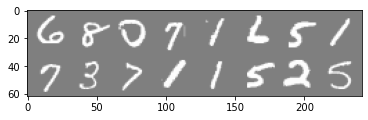

In [4]:
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('mnist_images', img_grid)

## Add projector to tensorboard

In [5]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

In [6]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [7]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
# select random images and their target indices
imagesx, labels = select_n_random(data_train.data, data_train.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = imagesx.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=labels,
                    label_img=imagesx.unsqueeze(1))
writer.close()

In [8]:
#!tensorboard --logdir=runs

## Load model

In [9]:
#net = Alexnet()
net = MyModule().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [10]:
writer.add_graph(net, images)
writer.close()

## Train Loop

In [17]:
# loop over the dataset multiple times
#with experiment.record(name='sample', exp_conf=conf):
def train(net, trainloader, optimizer, epoch=5):
    net.train()
    for epoch in range(epoch):
        running_loss = 0.0
        for batch_idx, data in enumerate(trainloader, 0):   
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 1000 == 999:    # every 1000 mini-batches...
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
                # ...log the running loss
                writer.add_scalar('training loss', running_loss / 1000, epoch * len(trainloader) + batch_idx)
                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('predictions vs. actuals', plot_classes_preds(net, inputs, labels, classes), global_step=epoch                 * len(trainloader) + batch_idx)

        print('Loss: {}'.format(running_loss))
    print('Finished Training')

In [18]:
train(net, trainloader, optimizer, epoch=100)

Train Epoch: 0 [1998/60000 (27%)]	Loss: 0.250808
Train Epoch: 0 [3998/60000 (53%)]	Loss: 0.004590
Train Epoch: 0 [5998/60000 (80%)]	Loss: 0.176379
Loss: 453.76140436101184
Train Epoch: 1 [1998/60000 (27%)]	Loss: 0.081183
Train Epoch: 1 [3998/60000 (53%)]	Loss: 0.117361
Train Epoch: 1 [5998/60000 (80%)]	Loss: 0.041741
Loss: 411.39996676927467
Train Epoch: 2 [1998/60000 (27%)]	Loss: 0.017423
Train Epoch: 2 [3998/60000 (53%)]	Loss: 0.044443
Train Epoch: 2 [5998/60000 (80%)]	Loss: 0.289924
Loss: 364.98402221496514
Train Epoch: 3 [1998/60000 (27%)]	Loss: 0.233235
Train Epoch: 3 [3998/60000 (53%)]	Loss: 0.008908
Train Epoch: 3 [5998/60000 (80%)]	Loss: 0.001403
Loss: 348.0347120591569
Train Epoch: 4 [1998/60000 (27%)]	Loss: 0.000030
Train Epoch: 4 [3998/60000 (53%)]	Loss: 0.258850
Train Epoch: 4 [5998/60000 (80%)]	Loss: 0.065478
Loss: 361.7245239192126
Train Epoch: 5 [1998/60000 (27%)]	Loss: 0.003977
Train Epoch: 5 [3998/60000 (53%)]	Loss: 0.000007
Train Epoch: 5 [5998/60000 (80%)]	Loss: 0.25

KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3fe7cd35-e1c3-486d-8a85-6e94f9a0da39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Reference

https://github.com/fepegar/torchio